In [ ]:
#https://thecleverprogrammer.com/2021/12/20/stress-detection-with-machine-learning/

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("stress.txt")
print(data.head())

          subreddit post_id sentence_range  \
0              ptsd  8601tu       (15, 20)   
1        assistance  8lbrx9         (0, 5)   
2              ptsd  9ch1zh       (15, 20)   
3     relationships  7rorpp        [5, 10]   
4  survivorsofabuse  9p2gbc         [0, 5]   

                                                text     id  label  \
0  He said he had not felt that way before, sugge...  33181      1   
1  Hey there r/assistance, Not sure if this is th...   2606      0   
2  My mom then hit me with the newspaper and it s...  38816      1   
3  until i met my new boyfriend, he is amazing, h...    239      1   
4  October is Domestic Violence Awareness Month a...   1421      1   

   confidence  social_timestamp  social_karma  syntax_ari  ...  \
0         0.8        1521614353             5    1.806818  ...   
1         1.0        1527009817             4    9.429737  ...   
2         0.8        1535935605             2    7.769821  ...   
3         0.6        1516429555       

In [2]:
print(data.isnull().sum())

subreddit                   0
post_id                     0
sentence_range              0
text                        0
id                          0
                           ..
lex_dal_avg_pleasantness    0
social_upvote_ratio         0
social_num_comments         0
syntax_fk_grade             0
sentiment                   0
Length: 116, dtype: int64


So this dataset does not have any null values. Now let’s prepare the text column of this dataset to clean the text column with stopwords, links, special symbols and language errors:

In [3]:
import nltk
import re
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
data["text"] = data["text"].apply(clean)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aozde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now let’s have a look at the most used words by the people sharing about their life problems on social media by visualizing a word cloud of the text column:

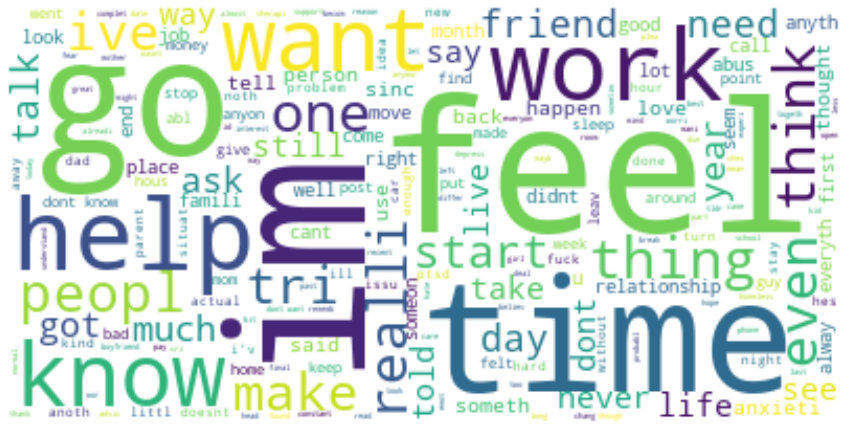

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(i for i in data.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Stress Detection Model
The label column in this dataset contains labels as 0 and 1. 0 means no stress, and 1 means stress. I will use Stress and No stress labels instead of 1 and 0. So let’s prepare this column accordingly and select the text and label columns for the process of training a machine learning model:

In [5]:
data["label"] = data["label"].map({0: "No Stress", 1: "Stress"})
data = data[["text", "label"]]
print(data.head())

                                                text      label
0  said felt way sugget go rest trigger ahead you...     Stress
1  hey rassist sure right place post goe  im curr...  No Stress
2  mom hit newspap shock would know dont like pla...     Stress
3  met new boyfriend amaz kind sweet good student...     Stress
4  octob domest violenc awar month domest violenc...     Stress


Now I will split this dataset into training and test sets:

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

x = np.array(data["text"])
y = np.array(data["label"])

cv = CountVectorizer()
X = cv.fit_transform(x)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, 
                                                test_size=0.33, 
                                                random_state=42)

As this task is based on the problem of binary classification, I will be using the Bernoulli Naive Bayes algorithm, which is one of the best algorithms for binary classification problems. So let’s train the stress detection model:

In [7]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model.fit(xtrain, ytrain)

BernoulliNB()

Now let’s test the performance of our model on some random sentences based on mental health:

In [8]:
user = input("Enter a Text: ")
data = cv.transform([user]).toarray()
output = model.predict(data)
print(output)

Enter a Text: People need to take care of their mental health
['No Stress']


In [9]:
user = input("Enter a Text: ")
data = cv.transform([user]).toarray()
output = model.predict(data)
print(output)

Enter a Text: Sometime I feel like I need some help
['Stress']
